In [11]:
''' use pca to extract characteristic of signal
then use rnn to fit; probably voigt function/Gaussian line shape'''
import os  
import numpy as np
import struct
import matplotlib.pyplot as plt
import gc
import random
import math

# from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
# from sklearn.decomposition import PCA as PCA

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
with open("dataset_test.bin", "rb") as file0:
    data1 = file0.read(4)
    NM1 = struct.unpack("i", data1)[0]
    sig2 = np.zeros((NM1,200),dtype = np.float32)
    an2 = np.zeros((NM1,4),dtype = np.float32)
    for i in range(NM1):
        for k in range(4):
            data1 = file0.read(4)
            an2[i,k] = struct.unpack("f", data1)[0]
        for k in range(200):
            data1 = file0.read(4)
            sig2[i,k] = struct.unpack("f", data1)[0]  
    # data1 = file0.read(len('end\0'))
    # end = struct.unpack("4s", data1)[0]  

In [3]:
with open("dataset.bin", "rb") as file0:
    data1 = file0.read(4)
    NM1 = struct.unpack("i", data1)[0]
    sig1 = np.zeros((NM1,200),dtype = np.float32)
    an1 = np.zeros((NM1,4),dtype = np.float32)
    for i in range(NM1):
        for k in range(4):
            data1 = file0.read(4)
            an1[i,k] = struct.unpack("f", data1)[0]
        for k in range(200):
            data1 = file0.read(4)
            sig1[i,k] = struct.unpack("f", data1)[0]  
    # data1 = file0.read(len('end\0'))
    # end = struct.unpack("4s", data1)[0]  

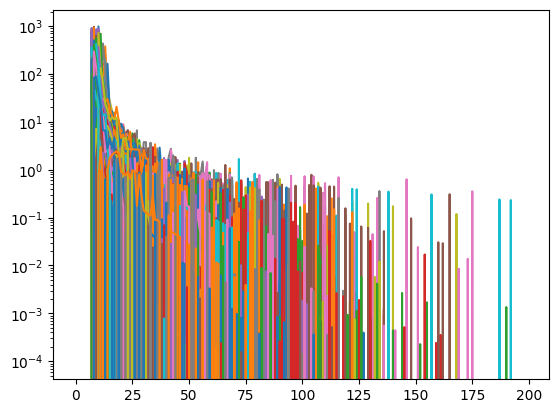

1262
[1.24224685e-02 9.14926987e+01 1.54261023e+03 8.50000024e-01]


In [4]:
plt.axes(yscale = "log") 
for n in range(sig1.shape[0]):
    plt.plot(sig1[n])
plt.show()
print(NM1)
print(an2[-1])

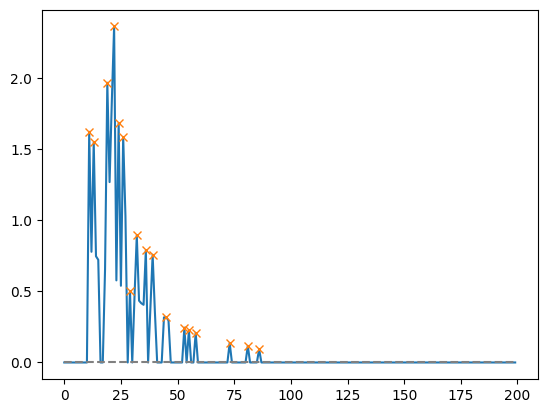

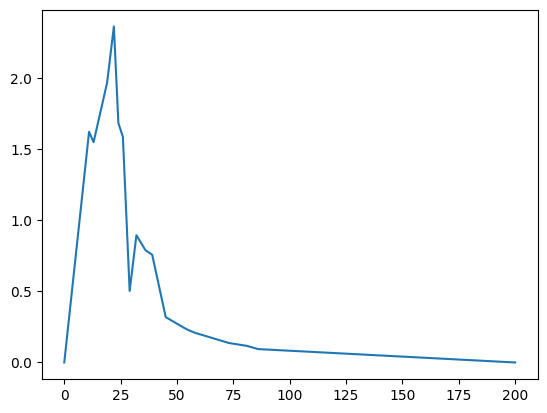

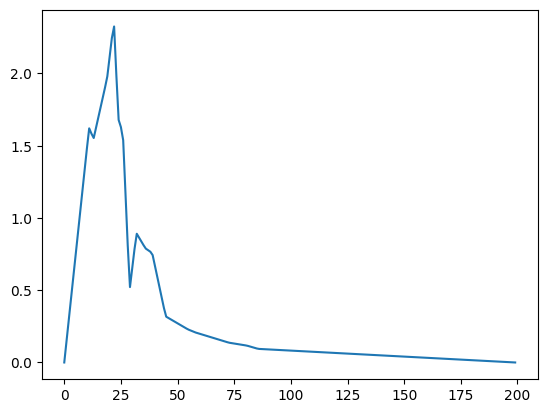

In [5]:
xsig = sig1[0]
peaks, _ = find_peaks(xsig, height=0)
plt.plot(xsig)
plt.plot(peaks, xsig[peaks], "x")
plt.plot(np.zeros_like(xsig), "--", color="gray")
plt.show()

x = np.zeros((peaks.shape[0]+2,))
y = np.zeros((peaks.shape[0]+2,))
x[1:-1] = peaks
y[1:-1] = xsig[peaks]
x[-1] = sig1.shape[1]
plt.plot(x,y)
plt.show()

f2 = interp1d(x, y, kind='linear')
N = 200
xnew = np.linspace(0, N,num=N)
ynew = f2(xnew)

# plt.axes(yscale = "log") 
plt.plot(ynew)
plt.show()

In [6]:
def smooth_peak(xsig):
    peaks, _ = find_peaks(xsig, height=0)
    # plt.plot(xsig)
    # plt.plot(peaks, xsig[peaks], "x")
    # plt.plot(np.zeros_like(xsig), "--", color="gray")
    # plt.show()
    if(peaks.shape[0]!=0):
        x = np.zeros((peaks.shape[0]+3,))
        y = np.zeros((peaks.shape[0]+3,))
        x[1:-2] = peaks
        y[1:-2] = xsig[peaks]
        x[-1] = sig1.shape[1]
        y[-1] = 0
        x[-2] = peaks[-1]+5
        y[-2] = 0
        # plt.plot(x,y)
        # plt.show()

        f2 = interp1d(x, y, kind='linear')
        N = xsig.shape[0]
        xnew = np.linspace(0, N,num=N)
        ynew = f2(xnew)
    
    else:
        ynew = np.zeros((xsig.shape[0],))
    
    return ynew
#     # plt.axes(yscale = "log") 
#     plt.plot(ynew)
#     plt.show()
    

In [7]:
msig1 = np.zeros((sig1.shape[0],sig1.shape[1]))
for i in range(sig1.shape[0]):
    msig1[i] = smooth_peak(sig1[i])
    
msig2 = np.zeros((sig2.shape[0],sig2.shape[1]))
for i in range(sig2.shape[0]):
    msig2[i] = smooth_peak(sig2[i])

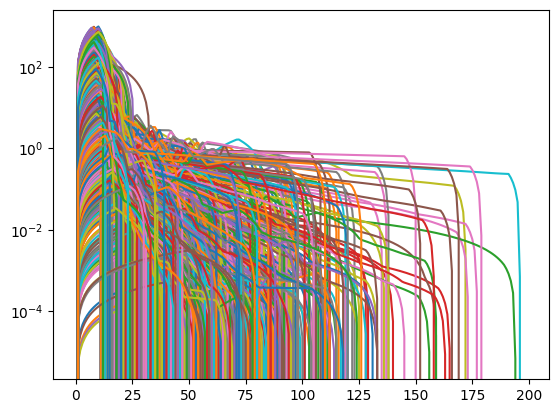

In [8]:
plt.axes(yscale = "log") 
for n in range(msig1.shape[0]):
    plt.plot(msig1[n])
plt.show()

In [9]:
print(sig1.shape)
print(an1.shape)
print(sig2.shape)
print(an2.shape)
# num_labels = 10
x_train = msig1
y_train = an1   # y_train : [thickness,mua,mus,g]
x_test = msig2
y_test = an2

x_train = (np.log10((x_train+1e-6)/1000)+9)/9   # 归一化
x_test = (np.log10((x_test+1e-6)/1000)+9)/9

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))    # reshape
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
d_train = np.reshape(y_train[:,0],(y_train[:,0].shape[0],1,1)) # add thickness of sample into input data
d_test = np.reshape(y_test[:,0],(y_test[:,0].shape[0],1,1))

y_train[:,1] = y_train[:,1]/1e2
y_test[:,1] = y_test[:,1]/1e2
y_train[:,2] = y_train[:,2]/200e2
y_test[:,2] = y_test[:,2]/200e2
y_train = y_train[:,1:3] # determine the nn to output mua/mus or mua+mus
y_test = y_test[:,1:3]
# y_train = labeling(y_train,num_labels)[:,1,:] # select to predict what : 0:thickness 1:mua 2: mus
# y_test = labeling(y_test,num_labels)[:,1,:]
print('x_train.shape = '+str(x_train.shape)) 
print('y_train.shape = '+str(y_train.shape)) 
print('d_train.shape = '+str(d_train.shape)) 


(1262, 200)
(1262, 4)
(30, 200)
(30, 4)
x_train.shape = (1262, 200, 1)
y_train.shape = (1262, 2)
d_train.shape = (1262, 1, 1)


In [42]:
# Model definition
input_x = Input(shape=(200, 1), name='x_input')
input_d = Input(shape=(1, 1), name='d_input')

lstm_layer = LSTM(64)(input_x)  # You can adjust the number of LSTM units
concat_layer = Concatenate()([lstm_layer, tf.squeeze(input_d, axis=-1)])
dense_layer = Dense(32, activation='relu')(concat_layer)  # You can adjust the number of Dense units
output_layer = Dense(2, activation='linear')(dense_layer)

model = Model(inputs=[input_x, input_d], outputs=output_layer)

# Model compilation
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

#shuffle the x_train , y_train , d_train
index = [i for i in range(x_train.shape[0])]  
np.random.shuffle(index) 
x_train = x_train[index]
y_train = y_train[index]
d_train = d_train[index]

# Split the data into training and validation sets
split_idx = int(0.8 * len(x_train))
x_train_set = x_train[:split_idx]
d_train_set = d_train[:split_idx]
y_train_set = y_train[:split_idx]

x_val_set = x_train[split_idx:]
d_val_set = d_train[split_idx:]
y_val_set = y_train[split_idx:]

# Fit the model
history = model.fit(
    [x_train_set, d_train_set],
    y_train_set,
    validation_data=([x_val_set, d_val_set], y_val_set),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
)


Epoch 1/100
32/32 [==============================] - 3s 40ms/step - loss: 0.3787 - mae: 0.3787 - val_loss: 0.2498 - val_mae: 0.2498
Epoch 2/100
32/32 [==============================] - 1s 22ms/step - loss: 0.2519 - mae: 0.2519 - val_loss: 0.2454 - val_mae: 0.2454
Epoch 3/100
32/32 [==============================] - 1s 22ms/step - loss: 0.2457 - mae: 0.2457 - val_loss: 0.2454 - val_mae: 0.2454
Epoch 4/100
32/32 [==============================] - 1s 21ms/step - loss: 0.2450 - mae: 0.2450 - val_loss: 0.2450 - val_mae: 0.2450
Epoch 5/100
32/32 [==============================] - 1s 22ms/step - loss: 0.2452 - mae: 0.2452 - val_loss: 0.2451 - val_mae: 0.2451
Epoch 6/100
32/32 [==============================] - 1s 21ms/step - loss: 0.2459 - mae: 0.2459 - val_loss: 0.2456 - val_mae: 0.2456
Epoch 7/100
32/32 [==============================] - 1s 22ms/step - loss: 0.2453 - mae: 0.2453 - val_loss: 0.2452 - val_mae: 0.2452
Epoch 8/100
32/32 [==============================] - 1s 22ms/step - loss: 0.

In [43]:
model = tf.keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate([x_test,d_test,], y_test)

print("Test error", test_acc)
print("Test loss", test_loss)

1/1 [==============================] - 0s 329ms/step - loss: 0.2726 - mae: 0.2726
Test error 0.2725600600242615
Test loss 0.2725600600242615


In [44]:
mua = np.zeros((x_train.shape[0],))
# mus = np.zeros((x_train.shape[0],))
d = np.zeros((x_train.shape[0],))
miu = np.zeros((x_train.shape[0],1))

miu = model.predict([x_train,d_train])
mua = miu[:,0]
mus = miu[:,1]
d = d_train[:,0,0]

In [45]:
err = np.zeros((x_train.shape[0],2))

err[:,0] = y_train[:,0]-mua
err[:,1] = y_train[:,1]-mus

# print(mua[k],mus[k],d[k])
# print(y_train[k])

In [46]:
k=np.random.randint(0,x_train.shape[0],1)[0]
print(mua[k],mus[k])
print(y_train[k])

0.49287957 0.4939728
[0.43761298 0.15814187]


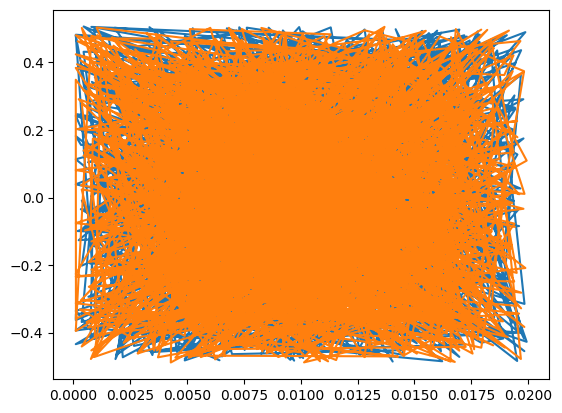

In [47]:
plt.plot(d,err[:,0])
plt.plot(d,err[:,1])
plt.show()

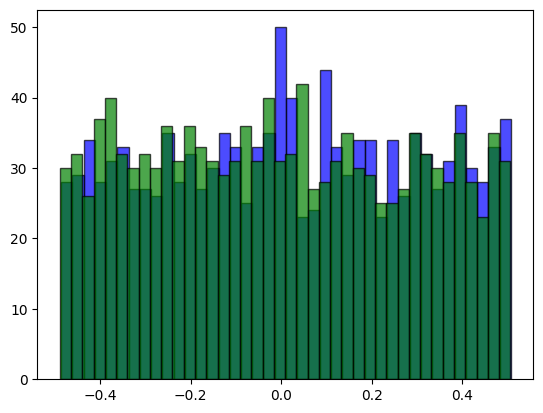

In [48]:
# print(mua,mus,d)
# print(an2[i,1],an2[i,2],an2[i,0])
# plt.plot(abs(an1[:,1]-mua))
# plt.plot(abs(an1[:,2]-mus))
plt.hist(err[:,0], bins=40,  facecolor="blue", edgecolor="black", alpha=0.7)
plt.hist(err[:,1], bins=40,  facecolor="green", edgecolor="black", alpha=0.7)
# plt.hist(abs(y_train[:,1]-mus), bins=40,  facecolor="green", edgecolor="black", alpha=0.7)
plt.show()

In [34]:
metric = "mean_absolute_error"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

KeyError: 'mean_absolute_error'

<Figure size 640x480 with 0 Axes>